# Regularization

In this exercise, we will try a few methods to prevent overfitting of an MLP network to training data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

## Regression problem
We will look at a regression problem where the task is to estimate a function of one variable
$$y = f(x)$$
using a set of training examples $(x_1, y_1), \ldots, (x_n, y_n)$.

Let us first generate training examples $y_i=\sin(x_i) + n_i$ with $x_i$ drawn from the uniform distribution in $[-0.5, 0.5]$ and noise $n_i$ drawn from the Gaussian distribution.

In [2]:
np.random.seed(1)
n = 150
x = np.random.rand(n, 1)-0.5

def fun(x):
    y = np.cos(2* np.pi * x)
    y += 0.3 * np.random.randn(*x.shape)
    return y

y = fun(x)

# Convert to PyTorch tensors
x = torch.tensor(x).float()
y = torch.tensor(y).float()

Let us split the data into training, validation and test sets and plot the training and validation sets. And let us plot the data.

In [3]:
# Split the data into training, validation and test sets
torch.manual_seed(3)
rp = torch.randperm(x.size(0))

n_train = int(x.size(0) * 0.5)
x_train, y_train = x[rp[:n_train]], y[rp[:n_train]]
x_test, y_test = x[rp[n_train:]], y[rp[n_train:]]

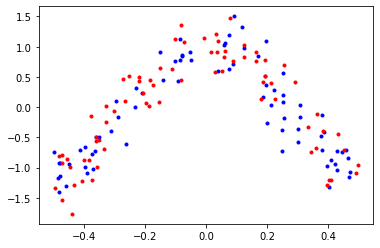

In [4]:
# Plot the data
fix, ax = plt.subplots(1)
ax.plot(x_train, y_train, 'b.')
ax.plot(x_test, y_test, 'r.')

## Define a multi-layer perceptron (MLP) network with two hidden layers

In the code below, we define a neural network architecture with:
* input dimension 1
* one hidden layer with 100 units with tanh nonlinearity
* one hidden layer with 100 units with tanh nonlinearity
* linear output layer with output dimension 1

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1))

    def forward(self, x):
        return self.net(x)

We will use the following functions to assess the quality of the trained network.

In [6]:
# This visualizes the function implemented by an MLP
def plot_fit(mlp, x, y):
    fig, ax = plt.subplots(1)
    ax.plot(x, y, '.')
    mlp.eval()
    with torch.no_grad():
        x = torch.tensor(np.linspace(-0.5, 0.5, 100).reshape((-1, 1))).float()
        pred = mlp.forward(x)
    ax.plot(x, pred)

# This is the function to compute the loss:
def compute_loss(mlp, x, y):
    mlp.eval()
    with torch.no_grad():
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        return loss.cpu().numpy()

# This is the function to print the progress during training
def print_progress(epoch, train_error, test_error):
    print(f'Epoch {epoch+1}: Train error: {train_error:.2f}, Test error: {test_error:.2f}')

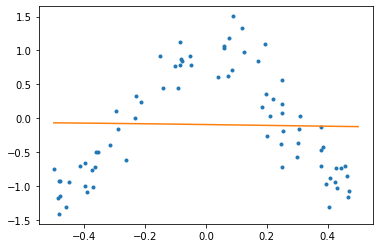

In [7]:
# Create an MLP
mlp = MLP()

# Plot the function implemented by the MLP
plot_fit(mlp, x_train, y_train)

## Train the MLP network without regularization
Training is done by minimizing the mean-squared error computed on the training data:
$$c=\sum_{i=1}^n || f(x_i) - y_i ||^2.$$

Here, we train the network:
* using all the data for computing the gradient (batch mode)
* using `n_epochs` epochs (which is equal to the number of parameter updates in the batch mode).

In [8]:
mlp = MLP()

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
n_epochs = 10000
train_errors = []
test_errors = []

for epoch in range(n_epochs):

    optimizer.zero_grad()
    outputs = mlp.forward(x_train)
    loss = F.mse_loss(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        train_errors.append(compute_loss(mlp, x_train, y_train))
        test_errors.append(compute_loss(mlp, x_test, y_test))
        print_progress(epoch, train_errors[-1], test_errors[-1])

Epoch 500: Train error: 0.07, Test error: 0.11
Epoch 1000: Train error: 0.07, Test error: 0.11
Epoch 1500: Train error: 0.07, Test error: 0.11
Epoch 2000: Train error: 0.06, Test error: 0.11
Epoch 2500: Train error: 0.06, Test error: 0.13
Epoch 3000: Train error: 0.05, Test error: 0.15
Epoch 3500: Train error: 0.05, Test error: 0.16
Epoch 4000: Train error: 0.05, Test error: 0.19
Epoch 4500: Train error: 0.04, Test error: 0.19
Epoch 5000: Train error: 0.03, Test error: 0.20
Epoch 5500: Train error: 0.03, Test error: 0.21
Epoch 6000: Train error: 0.02, Test error: 0.22
Epoch 6500: Train error: 0.02, Test error: 0.22
Epoch 7000: Train error: 0.02, Test error: 0.23
Epoch 7500: Train error: 0.02, Test error: 0.25
Epoch 8000: Train error: 0.02, Test error: 0.25
Epoch 8500: Train error: 0.02, Test error: 0.27
Epoch 9000: Train error: 0.01, Test error: 0.27
Epoch 9500: Train error: 0.02, Test error: 0.28
Epoch 10000: Train error: 0.02, Test error: 0.27


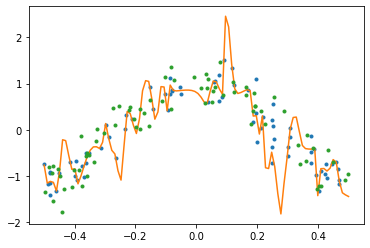

In [9]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)
plt.plot(x_test, y_test, '.')

As you can see, the network overfits to the training data.

In [10]:
test_loss_no_regularization = compute_loss(mlp, x_test, y_test)
print("Test loss without regularization: %.5f" % test_loss_no_regularization)

Test loss without regularization: 0.27465


## Early stopping

One of the simplest ways to avoid overfitting is to stop training when the validation error starts to grow.

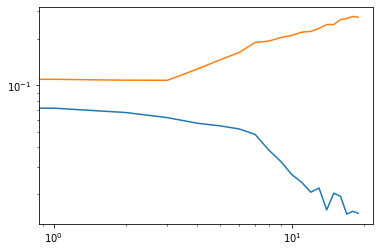

In [11]:
# Let us look at the learning curves: the evolution of training and validation errors during training
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(test_errors)

In the code below, define a stopping creterion in function `stop_criterion`. Training should be stopped (function returns  `True`) when the validation error is larger than the best validation error obtained so far (with given `tolerance`) for `patience` epochs.

In [12]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int):    Maximum number of epochs with unsuccessful updates.
          tolerance (float): We assume that the update is unsuccessful if the validation error is larger
                              than the best validation error so far plus this tolerance.
        """
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, test_errors):
        """
        Args:
          test_errors (iterable): Validation errors after every update during training.
        
        Returns: True if training should be stopped: when the validation error is larger than the best
                  validation error obtained so far (with given tolearance) for patience epochs (number of consecutive epochs for which the criterion is satisfied).
                 
                 Otherwise, False.
        """
        if len(test_errors) <= self.patience:
            return False

        min_val_error = min(test_errors)
        test_errors = np.array(test_errors[-self.patience:])
        return all(test_errors > min_val_error + self.tolerance)

In [13]:
# Let's train the network with early stopping
mlp = MLP()

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
n_epochs = 10000
train_errors = []
test_errors = []
early_stop = EarlyStopping(tolerance=0.005, patience=20)

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = mlp.forward(x_train)
    loss = F.mse_loss(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_errors.append(compute_loss(mlp, x_train, y_train))
    test_errors.append(compute_loss(mlp, x_test, y_test))

    if early_stop.stop_criterion(test_errors):
        print(test_errors[epoch])
        print('Stop after %d epochs' % epoch)
        break
        
    if (epoch+1) % 50 == 0:
        print_progress(epoch, train_errors[epoch], test_errors[epoch])

Epoch 50: Train error: 0.53, Test error: 0.59
Epoch 100: Train error: 0.12, Test error: 0.14
Epoch 150: Train error: 0.08, Test error: 0.11
Epoch 200: Train error: 0.08, Test error: 0.11
Epoch 250: Train error: 0.08, Test error: 0.11
0.10811922
Stop after 283 epochs


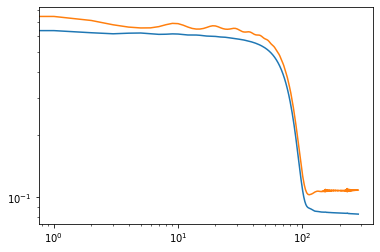

In [14]:
# Plot the learning curves: the evolution of training and validation errors during training
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(test_errors)

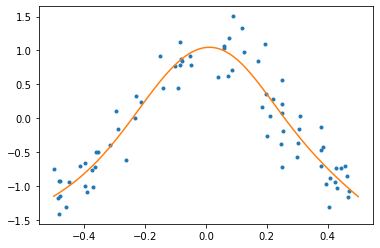

In [15]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [16]:
test_loss_early_stopping = compute_loss(mlp, x_test, y_test)
print("Test loss with early stopping: %.5f" % test_loss_early_stopping)

Test loss with early stopping: 0.10812


## Weight-decay regularization

Let us train the same network with L2 penalties on the weights. In PyTorch, one can add L2 penalty terms for all the parameters by providing `weight_decay` argument for most types of optimizers.

In [17]:
# Train an MLP with L2 regularization
mlp = MLP()

# Create an Adam optimizer with learning rate 0.01 and weight decay parameter 0.001
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=0.001)
n_epochs = 4000
train_errors = []
test_errors = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = mlp.forward(x_train)
    loss = F.mse_loss(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        train_errors.append(compute_loss(mlp, x_train, y_train))
        test_errors.append(compute_loss(mlp, x_test, y_test))
        print_progress(epoch, train_errors[-1], test_errors[-1])

Epoch 500: Train error: 0.08, Test error: 0.11
Epoch 1000: Train error: 0.08, Test error: 0.11
Epoch 1500: Train error: 0.08, Test error: 0.11
Epoch 2000: Train error: 0.08, Test error: 0.11
Epoch 2500: Train error: 0.08, Test error: 0.11
Epoch 3000: Train error: 0.08, Test error: 0.11
Epoch 3500: Train error: 0.08, Test error: 0.11
Epoch 4000: Train error: 0.08, Test error: 0.11


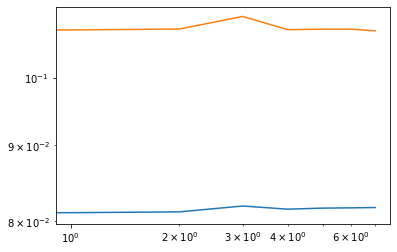

In [18]:
# Plot the learning curves (the evolution of the following quantities during training)
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(test_errors)

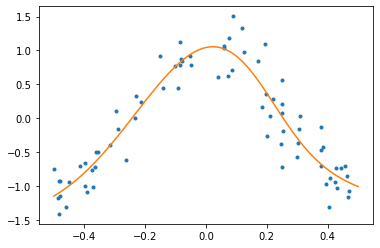

In [19]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [20]:
test_loss_weight_decay = compute_loss(mlp, x_test, y_test)
print("Test loss with weight decay: %.5f" % test_loss_weight_decay)

Test loss with weight decay: 0.10754


## Injecting noise to inputs

One way to improve generalization is to add noise to the inputs. So, we update the parameters of $f$ using the gradient of the following function
$$c= \sum_{i=1}^n || f(x_i + n_i) - y_i ||^2$$
where $n_i$ is a noise instance. In the code, we corrupt input with Gaussian noise with standard deviation 0.07.

In [21]:
# Train MLP with injecting noise to inputs
mlp = MLP()

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
n_epochs = 4000
train_errors = []
test_errors = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = mlp.forward(x_train + 0.07 * torch.randn_like(x_train))
    loss = F.mse_loss(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        train_errors.append(compute_loss(mlp, x_train, y_train))
        test_errors.append(compute_loss(mlp, x_test, y_test))
        print_progress(epoch, train_errors[-1], test_errors[-1])

Epoch 100: Train error: 0.11, Test error: 0.13
Epoch 200: Train error: 0.11, Test error: 0.14
Epoch 300: Train error: 0.09, Test error: 0.12
Epoch 400: Train error: 0.09, Test error: 0.12
Epoch 500: Train error: 0.09, Test error: 0.12
Epoch 600: Train error: 0.09, Test error: 0.12
Epoch 700: Train error: 0.09, Test error: 0.13
Epoch 800: Train error: 0.09, Test error: 0.12
Epoch 900: Train error: 0.10, Test error: 0.14
Epoch 1000: Train error: 0.09, Test error: 0.13
Epoch 1100: Train error: 0.09, Test error: 0.12
Epoch 1200: Train error: 0.09, Test error: 0.12
Epoch 1300: Train error: 0.09, Test error: 0.13
Epoch 1400: Train error: 0.09, Test error: 0.12
Epoch 1500: Train error: 0.09, Test error: 0.12
Epoch 1600: Train error: 0.09, Test error: 0.12
Epoch 1700: Train error: 0.09, Test error: 0.12
Epoch 1800: Train error: 0.09, Test error: 0.12
Epoch 1900: Train error: 0.09, Test error: 0.12
Epoch 2000: Train error: 0.09, Test error: 0.11
Epoch 2100: Train error: 0.09, Test error: 0.12
E

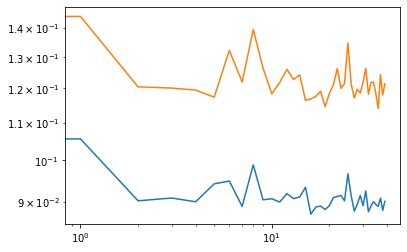

In [22]:
# Plot the learning curves: the evolution of training and validation errors during training
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(test_errors)

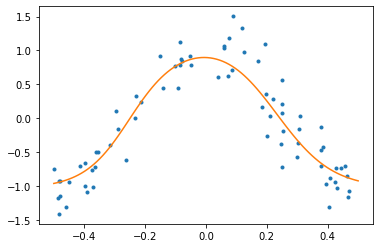

In [23]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [24]:
# Let's look at the test loss
test_loss_inj_noise = compute_loss(mlp, x_test, y_test)
print("Test loss with noise injection: %.5f" % test_loss_inj_noise)

Test loss with noise injection: 0.12143


## Dropout

Another way to improve generalization is to use dropout. In the cell below, we define an MLP with exactly the same architecture as previously but with `nn.Dropout` layers (with dropout probability 0.2) after each `tanh`
nonlinearity. 

In [25]:
class MLPDropout(nn.Module):
    def __init__(self):
        super(MLPDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(100, 1))
        
    def forward(self, x):
        return self.net(x)

In [26]:
mlp = MLPDropout()

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
#scheduler = StepLR(optimizer, step_size=100, gamma=0.95)
n_epochs = 4000
train_errors = []
test_errors = []

for epoch in range(n_epochs):
    #scheduler.step()
    mlp.train()  # Dropout layers work differently during training and test. This sets the training mode.
    optimizer.zero_grad()
    outputs = mlp.forward(x_train)
    loss = F.mse_loss(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        mlp.eval()
        train_errors.append(compute_loss(mlp, x_train, y_train))
        test_errors.append(compute_loss(mlp, x_test, y_test))
        print_progress(epoch, train_errors[-1], test_errors[-1])

Epoch 100: Train error: 0.09, Test error: 0.12
Epoch 200: Train error: 0.09, Test error: 0.13
Epoch 300: Train error: 0.09, Test error: 0.11
Epoch 400: Train error: 0.08, Test error: 0.11
Epoch 500: Train error: 0.08, Test error: 0.11
Epoch 600: Train error: 0.08, Test error: 0.11
Epoch 700: Train error: 0.09, Test error: 0.12
Epoch 800: Train error: 0.08, Test error: 0.11
Epoch 900: Train error: 0.08, Test error: 0.12
Epoch 1000: Train error: 0.08, Test error: 0.11
Epoch 1100: Train error: 0.08, Test error: 0.10
Epoch 1200: Train error: 0.08, Test error: 0.11
Epoch 1300: Train error: 0.08, Test error: 0.11
Epoch 1400: Train error: 0.08, Test error: 0.11
Epoch 1500: Train error: 0.08, Test error: 0.11
Epoch 1600: Train error: 0.07, Test error: 0.11
Epoch 1700: Train error: 0.08, Test error: 0.10
Epoch 1800: Train error: 0.08, Test error: 0.11
Epoch 1900: Train error: 0.08, Test error: 0.11
Epoch 2000: Train error: 0.08, Test error: 0.13
Epoch 2100: Train error: 0.08, Test error: 0.11
E

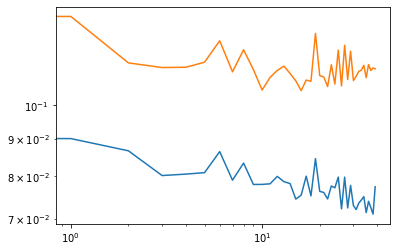

In [27]:
# Plot the learning curves (the evolution of the following quantities during training)
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(test_errors)

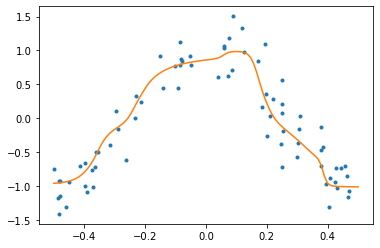

In [28]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [29]:
# Let's look at the test loss
test_loss_dropout = compute_loss(mlp, x_test, y_test)
print("Test loss with dropout: %.5f" % test_loss_dropout)

Test loss with dropout: 0.11205


## Reducing model capacity

Another simple way to reduce overfitting is to reduce the capacity of the model. Let us use for the same regression task a much smaller network: an MLP with one hidden layer with five units, tanh nonlinearity in the hidden layer and a linear output layer.

In [30]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 5),
            nn.Tanh(),
            nn.Linear(5, 1))
    
    def forward(self, x):
        return self.net(x)

In [31]:
mlp = MLPSmall()

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
n_epochs = 10000
train_errors = []
test_errors = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = mlp.forward(x_train)
    loss = F.mse_loss(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        train_errors.append(compute_loss(mlp, x_train, y_train))
        test_errors.append(compute_loss(mlp, x_test, y_test))
        print_progress(epoch, train_errors[-1], test_errors[-1])

Epoch 500: Train error: 0.61, Test error: 0.66
Epoch 1000: Train error: 0.60, Test error: 0.66
Epoch 1500: Train error: 0.57, Test error: 0.63
Epoch 2000: Train error: 0.45, Test error: 0.50
Epoch 2500: Train error: 0.23, Test error: 0.27
Epoch 3000: Train error: 0.11, Test error: 0.13
Epoch 3500: Train error: 0.09, Test error: 0.10
Epoch 4000: Train error: 0.08, Test error: 0.10
Epoch 4500: Train error: 0.08, Test error: 0.10
Epoch 5000: Train error: 0.08, Test error: 0.11
Epoch 5500: Train error: 0.08, Test error: 0.11
Epoch 6000: Train error: 0.08, Test error: 0.11
Epoch 6500: Train error: 0.08, Test error: 0.11
Epoch 7000: Train error: 0.08, Test error: 0.11
Epoch 7500: Train error: 0.08, Test error: 0.11
Epoch 8000: Train error: 0.08, Test error: 0.11
Epoch 8500: Train error: 0.08, Test error: 0.11
Epoch 9000: Train error: 0.08, Test error: 0.11
Epoch 9500: Train error: 0.08, Test error: 0.11
Epoch 10000: Train error: 0.08, Test error: 0.11


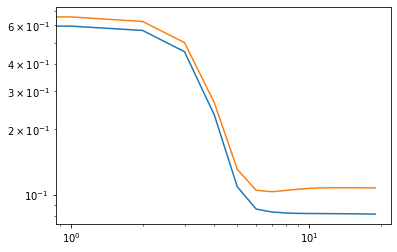

In [32]:
# Plot the learning curves (the evolution of the following quantities during training)
fig, ax = plt.subplots(1)
ax.loglog(train_errors)
ax.loglog(test_errors)

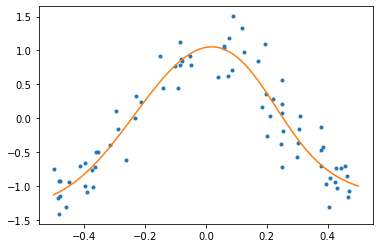

In [33]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [34]:
# Let's look at the test loss
test_loss_small = compute_loss(mlp, x_test, y_test)
print("Test loss by reducing model capacity: %.5f" % test_loss_small)

Test loss by reducing model capacity: 0.10763


In [35]:
# We can summarize the results obtained with different regularization methods:
print('No regularization: %.5f' % test_loss_no_regularization)
print('Early stopping:    %.5f' % test_loss_early_stopping)
print('Weight decay:      %.5f' % test_loss_weight_decay)
print('Noise injection:   %.5f' % test_loss_inj_noise)
print('Dropout:           %.5f' % test_loss_dropout)
print('Small network:     %.5f' % test_loss_small)

No regularization: 0.27465
Early stopping:    0.10812
Weight decay:      0.10754
Noise injection:   0.12143
Dropout:           0.11205
Small network:     0.10763


The values of the hyperparameters (parameters of the training procedure) may have a major impact on the results. The best hyperparameters are usually found by measuring the performance on the validation set.